In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
from tqdm.notebook import tqdm

## Ссылки:
* [Chris Olah's blog (LSTM/GRU)](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [PyTorch tutorial - RNN for name classification](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)
* [MNIST classification with RNN tutorial](https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79)
* [Good tutorials about Torch sentiment](https://github.com/bentrevett/pytorch-sentiment-analysis)

## Vanilla RNN

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png" width="600">

$$\Large h_{i+1} = tanh(W_x \cdot X_{i+1} + W_y \cdot h_{i})$$

Рекурретные нейросети нужны для работы с **последовательными данными** произвольной длины. Они представляют собой абстрактные ячейки, у которых есть какая-то **память** (hidden state), которая обновляется после обработки очередной порции данных.

Если в самом простом виде, то в рекуррентных сетках для одного входного вектора $x_{(t)}$ и одного слоя рекуррентной сети справедливо такое соотношение:

$$y_{(t)} = \phi (x_{(t)}^T \cdot w_x + y_{(t-1)}^T \cdot w_y + b)$$

где 
* $x(t)$ — входной вектор на текущем шаге;
* $y(t)$ — выходной вектор на текущем шаге;
* $w_x$ — вектор весов нейронов для входа;
* $w_y$ — вектор весов нейронов для выхода;
* $y(t-1)$ — выходной вектор с прошлого шага (для первого шага этот вектор нулевой);
* $b$ — bias;
* $\phi$ — какая-то функция активации (например, ReLU).

Эту ячейку применяют по очереди ко всей последовательности, пробрасывая hidden state с предыдущего состояния. С точки зрения построения вычислительного графа это выглядит так:

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png" width="600">

То есть если зафиксировать длину последовательности, то мы получим обычный фиксированный ациклический граф вычислений, в котором просто пошерены параметры всех ячеек.

### Упрощение формулы

Снова немножко математики чтобы привести формулу выше к более удобному виду.

Представим, что на вход подается не один вектор $x_{(t)}$, а целый мини-батч размера $m$ таких векторов $X_{(t)}$, соответственно все дальнейшие размышления мы уже производим в матричном виде:

$$ Y_{(t)} = \phi(X_{(t)}^T \cdot W_x + Y_{(t-1)}^T \cdot W_y + b) = \phi([X_{(t)} Y_{(t-1)}] \cdot W + b) $$
где
$$ W = [W_x W_y]^T $$

*Операция в квадратных скобках — конкатенация матриц

По размерностям:
* $Y_{(t)}$ — матрица [$m$ x n_neurons]
* $X_{(t)}$ — матрица [$m$ x n_features]
* $b$ — вектор длины n_neurons
* $W_x$ — веса между входами и нейронами размерностью [n_features x n_neurons]
* $W_y$ — веса связей с прошлым выходом размерностью [n_neurons x n_neurons]

# RNN from scratch

**Disclaimer:** не используйте самописные RNN-ки в реальной жизни.

Давайте реализуем торчовый модуль, который это реализует.

In [ ]:
input_size=5 ; hidden_size=6 ; batch_size=4
hidden = torch.randn((batch_size, hidden_size))
print(hidden.shape)
input = torch.randn((batch_size, input_size))
print(input.shape)
torch.cat([input, hidden], 1).shape

torch.Size([4, 6])
torch.Size([4, 5])


torch.Size([4, 11])

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()

        self.hidden_size = hidden_size
        self.W = nn.Linear(input_size+hidden_size, hidden_size)
        self.T = nn.Tanh()
        # <создать Wx, Wy?>

    def forward(self, input_data, hidden):
        # <использовать Wx, Wy для полученния нового hidden>
        hidden = self.T(self.W.forward(torch.cat([input_data, hidden], dim=1)))
        return hidden

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

In [ ]:
input_feature_size = 6
hidden_size=5
batch_size=3

In [ ]:
rnn = RNN(input_size=input_feature_size, hidden_size=hidden_size)
initial_hidden = rnn.init_hidden(batch_size)

In [ ]:
input_example = torch.rand([batch_size, input_feature_size])
new_hidden = rnn(input_example, initial_hidden)

In [ ]:
print(new_hidden.shape)

torch.Size([3, 5])


In [ ]:
print("initial_hidden: ", initial_hidden.numpy())
print("new_hidden: ", new_hidden.detach().numpy())

initial_hidden:  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
new_hidden:  [[ 0.32575917 -0.29269063 -0.3305174  -0.55169535 -0.28606996]
 [ 0.26261163 -0.20953883 -0.2653708  -0.15198083 -0.30244273]
 [ 0.3692083  -0.2983073  -0.35519534 -0.50031036 -0.24051736]]


In [ ]:
new_hidden = rnn(input_example, new_hidden)
print("new_hidden: ", new_hidden.detach().numpy())

new_hidden:  [[ 0.14283784 -0.6115067  -0.07733197 -0.4661197  -0.47606856]
 [ 0.1659417  -0.4404755  -0.11805464 -0.11240094 -0.42291087]
 [ 0.18339007 -0.6030841  -0.08293603 -0.41980648 -0.44645393]]


**Задание**. Модифицируйте код так, чтобы на вход можно было подавать батчи размером больше 1.

# Классификация картинок с RNN

Представьте, что у вас есть какая-то длинная картинка, в которой свёртки точно не зайдут. Например, снимки со спутника, спектрограмма или длиннокот.

Можно обработать их построчно с помощью рекуррентных сетей — просто подавать в качестве входа все пиксели очередной строки.

<img src="https://cdn-images-1.medium.com/max/2000/1*wFYZpxTTiXVqncOLQd_CIQ.jpeg" width="800">

In [ ]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


Загружаем данные

In [ ]:
import torchvision
import torchvision.transforms as transforms

BATCH_SIZE = 64

# переводим все в тензоры
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
!ls -lh data/

total 8.0K
drwxr-xr-x 3 root root 4.0K May  9 14:56 imdb
drwxr-xr-x 4 root root 4.0K May  9 19:38 MNIST


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['text', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


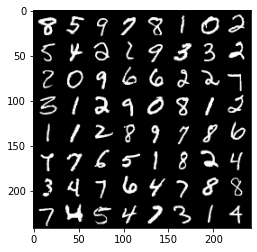

In [ ]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## Как выглядит классификация с RNN в общем виде 

<img src="https://cdn-images-1.medium.com/max/1600/1*vhAfRLlaeOXZ-bruv7Ostg.png" width="400">

In [ ]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super().__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)    

        out = self.FC(self.hidden)

        return out.view(-1, self.n_outputs) # batch_size X n_output

In [ ]:
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 10

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
logits = model(images.view(-1, 28,28))
print(logits[0:10])

tensor([[ 0.0338, -0.0363, -0.0640, -0.0041,  0.1045,  0.1140,  0.0442, -0.1333,
          0.0136,  0.0434],
        [ 0.0365, -0.0348, -0.0845, -0.0028,  0.0552,  0.1414,  0.0432, -0.1684,
          0.0333,  0.0376],
        [ 0.0556, -0.0446, -0.0773, -0.0237,  0.1218,  0.1221,  0.0514, -0.1231,
          0.0282,  0.0631],
        [ 0.0497, -0.0435, -0.0758, -0.0210,  0.1212,  0.1182,  0.0538, -0.1290,
          0.0292,  0.0598],
        [ 0.0501, -0.0547, -0.0717, -0.0127,  0.1159,  0.1090,  0.0476, -0.1296,
          0.0184,  0.0574],
        [ 0.0337, -0.0518, -0.0724, -0.0050,  0.1199,  0.1122,  0.0635, -0.1487,
          0.0168,  0.0537],
        [ 0.0422, -0.0533, -0.0766, -0.0019,  0.1099,  0.1069,  0.0424, -0.1490,
          0.0016,  0.0476],
        [ 0.0327, -0.0558, -0.0412,  0.0048,  0.1351,  0.1014,  0.0956, -0.1362,
          0.0519,  0.0457],
        [ 0.0511, -0.0504, -0.0684, -0.0013,  0.1068,  0.1073,  0.0405, -0.1358,
          0.0053,  0.0620],
        [ 0.0469, -

## Обучаем

In [ ]:
import torch.optim as optim

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [ ]:
for epoch in range(N_EPHOCS):
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        # model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 0.6604 | Train Accuracy: 78.92
Epoch:  1 | Loss: 0.2806 | Train Accuracy: 91.88
Epoch:  2 | Loss: 0.2173 | Train Accuracy: 93.83
Epoch:  3 | Loss: 0.1871 | Train Accuracy: 94.67
Epoch:  4 | Loss: 0.1617 | Train Accuracy: 95.47
Epoch:  5 | Loss: 0.1493 | Train Accuracy: 95.79
Epoch:  6 | Loss: 0.1411 | Train Accuracy: 95.97
Epoch:  7 | Loss: 0.1340 | Train Accuracy: 96.21
Epoch:  8 | Loss: 0.1219 | Train Accuracy: 96.66
Epoch:  9 | Loss: 0.1188 | Train Accuracy: 96.71


### Смотрим что на тесте

In [ ]:
test_acc = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 97.15


# Сентимент анализ

Домашка — классифицировать отзывы с IMDB на положительный / отрицательный только по тексту.

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment1.png">

Суть такая же, только нужно предобработать тексты — каждому слову сопоставить обучаемый вектор (embedding), который пойдёт дальше в RNN.

In [ ]:
# это уберет боль работы с текстами
!pip install torchtext==0.9
!python -m spacy download en

     |████████████████████████████████| 7.1 MB 10.1 MB/s 
     |████████████████████████████████| 735.5 MB 15 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.12.0
    Uninstalling torchtext-0.12.0:
      Successfully uninstalled torchtext-0.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.8.0 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.8.0 which is incompatible.
     |████████████████████████████████| 12.0 MB 13.0 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/

**Примечание.** Torchtext уже не очень живой проект, а в spacy нет русского.


In [ ]:
import torch
import torchtext

from torchtext.legacy import data

SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize='spacy',
                  include_lengths = True,
                  )
LABEL = data.LabelField(dtype=torch.float)

In [ ]:
from torchtext.legacy import datasets
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL, root="./data")

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:08<00:00, 9.61MB/s]


In [ ]:
ls -lh data/imdb/aclImdb/

total 1.7M
-rw-r--r-- 1 7297 1000 882K Jun 11  2011 imdbEr.txt
-rw-r--r-- 1 7297 1000 827K Apr 12  2011 imdb.vocab
-rw-r--r-- 1 7297 1000 4.0K Jun 26  2011 README
drwxr-xr-x 4 7297 1000 4.0K Apr 12  2011 test/
drwxr-xr-x 5 7297 1000 4.0K Jun 26  2011 train/


In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


In [ ]:
print(vars(train_data.examples[0]))

{'text': ['My', 'kids', 'recently', 'started', 'watching', 'the', 'reruns', 'of', 'this', 'show', '-', 'both', 'the', 'early', 'episodes', 'on', 'the', 'N', ',', 'and', 'the', 'later', 'ones', 'on', 'ABC', 'Family', '-', 'and', 'they', 'love', 'it', '.', '(', 'I', 'was', "n't", 'aware', 'the', 'show', 'had', 'even', 'lasted', 'past', 'the', 'first', 'or', 'second', 'season', ')', 'I', "'m", 'curious', 'as', 'to', 'what', 'prompted', 'all', 'of', 'the', 'cast', 'changes', '-', 'I', "'ve", 'seen', 'them', 'described', 'as', '"', 'highly', 'publicized', ',', '"', 'and', 'yet', 'a', 'half', 'hours', 'searching', 'efforts', 'on', 'the', 'web', 'have', 'revealed', 'nothing', 'but', 'endless', 'comments', 'on', 'how', 'the', 'early', 'episodes', 'were', 'so', 'much', 'better', 'than', 'the', 'later', 'episodes', '.', '(', 'Personally', ',', 'I', 'do', "n't", 'see', 'a', 'whole', 'lot', 'of', 'difference', '-', 'the', 'scripts', 'and', 'themes', 'remain', 'largely', 'the', 'same', 'throughout'

In [ ]:
# Сделаем еще eval
import random

train_data, valid_data = train_data.split(random_state=random.seed(SEED))

In [ ]:
# Сделаем словарь
TEXT.build_vocab(train_data, 
                 max_size=25000,
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_data)

.vector_cache/glove.6B.zip: 862MB [02:42, 5.29MB/s]                           
100%|█████████▉| 399999/400000 [00:19<00:00, 20753.80it/s]


In [ ]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


In [ ]:
vars(LABEL.vocab)

{'freqs': Counter({'neg': 8810, 'pos': 8690}),
 'itos': ['neg', 'pos'],
 'stoi': defaultdict(None, {'neg': 0, 'pos': 1}),
 'unk_index': None,
 'vectors': None}

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')
print(f'Number of testing examples: {len(valid_data)}')

Number of training examples: 17500
Number of testing examples: 25000
Number of testing examples: 7500


Почему 25002, а не 25000?
Потому что $<unk>$ и $<pad>$

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment6.png" width="160">

In [ ]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 202702), (',', 192061), ('.', 165818), ('and', 109282), ('a', 108997), ('of', 100574), ('to', 93690), ('is', 76644), ('in', 61161), ('I', 53931), ('it', 53383), ('that', 49271), ('"', 44317), ("'s", 43425), ('this', 42208), ('-', 36689), ('/><br', 35432), ('was', 34917), ('as', 30547), ('with', 29965)]


* stoi (string to int)
* itos (int to string)

In [ ]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']


In [ ]:
print(LABEL.vocab.stoi)

defaultdict(None, {'neg': 0, 'pos': 1})


In [ ]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# собираем батчи так, чтобы в каждом батче были примеры наиболее похожей длины
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE,
    sort_within_batch = True,
    device=device)

## Делаем модель

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment7.png" width="450">

* В эмбеддер (emb = [torch.nn.Embedding(num_embeddings, embedding_dim)](https://pytorch.org/docs/stable/nn.html?highlight=embedding#torch.nn.Embedding)) запихиваем тензор размерностью **[sentence length, batch size]**
* Эмбеддер возвращает тензор размерностью **[sentence length, batch size, embedding dim]**
* RNN (torch.nn.RNN(embedding_dim, hidden_dim)) возвращает 2 тензора, *output* размера [sentence length, batch size, hidden dim] и *hidden* размера [1, batch size, hidden dim]

In [ ]:
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_dim, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout_probability,
                 pad_idx,
                 ):
        super().__init__()
        self.bidirectional = bidirectional
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=pad_idx)
        self.hidden_dim = hidden_dim
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers,
                           batch_first=False, 
                           bidirectional=bidirectional,
                           dropout=dropout_probability)
        self.fc = nn.Sequential(
                      nn.Linear(hidden_dim*2, 200),
                      nn.ReLU(),
                      nn.Linear(200, 10),
                      nn.ReLU(),
                      nn.Linear(10, output_dim),
        )
        self.dropout = nn.Dropout(dropout_probability)

    def forward(self, text, text_lengths):

        embedded = self.dropout(self.embedding(text))

        packed_embedded = torch.nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))

        packed_output, (hidden_state, cell_state) = self.rnn(packed_embedded)
        
        unpacked_output = torch.nn.utils.rnn.pad_packed_sequence(packed_output)

        return self.fc(self.dropout(torch.cat((hidden_state[-1, :, :], hidden_state[-2, :, :]), dim=1)))

In [ ]:
# код обучения тоже пишите вы:)

In [ ]:
len(TEXT.vocab)

25002

In [ ]:
INPUT_DIM=len(TEXT.vocab)
EMBEDDING_DIM=100
HIDDEN_DIM=200
N_LAYERS = 2
BIDIRECTIONAL=True
DROPOUT_PROBABILITY=0.4
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
OUTPUT_DIM = 2

model = RNN(input_dim=INPUT_DIM, 
            embedding_dim=EMBEDDING_DIM, 
            hidden_dim=HIDDEN_DIM, 
            n_layers=N_LAYERS,
            bidirectional=BIDIRECTIONAL,
            dropout_probability=DROPOUT_PROBABILITY,
            pad_idx=PAD_IDX,
            output_dim=OUTPUT_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.85)
criterion = nn.CrossEntropyLoss()
losses = []
mean_losses = []

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,028,832 trainable parameters


In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

model.embedding.weight.data.copy_(pretrained_embeddings)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)

torch.Size([25002, 100])


In [ ]:
def count_test_accuracy(model, test):
    model.eval()
    test_accuracy = 0
    for batch in test:
        text, text_length = batch.text
        label = batch.label

        output = model(text, text_length)
        test_accuracy += get_accuracy(output, label, batch_size=text.shape[1])
    model.train()
    return test_accuracy / len(test)

In [ ]:
for epoch in tqdm(range(6)):
    train_accuracy = 0
    epoch_losses = []
    for batch in train_iterator:
        text, text_length  = batch.text
        label = batch.label
        optimizer.zero_grad()

        output = model(text, text_length)
        loss = criterion(output, label.long())

        losses.append(loss.item())
        epoch_losses.append(loss.item())
        train_accuracy += get_accuracy(output, label, batch_size=text.shape[1])

        loss.backward()
        optimizer.step()
    mean_losses.append(np.mean(epoch_losses))
    print(epoch, 'epoch loss =', np.mean(epoch_losses))
    print('train accuracy =', train_accuracy / len(train_iterator))
    print('test accuracy =', count_test_accuracy(model, test_iterator))
    scheduler.step()

  0%|          | 0/6 [00:00<?, ?it/s]

0 epoch loss = 0.6920408204089116
train accuracy = 52.1637122161197
test accuracy = 60.91831841432225
1 epoch loss = 0.643811625938346
train accuracy = 62.612421801490505
test accuracy = 73.80195012787723
2 epoch loss = 0.4552609298894875
train accuracy = 79.00237878395693
test accuracy = 82.13475063938618
3 epoch loss = 0.3297789166987377
train accuracy = 86.4051094890511
test accuracy = 86.27237851662404
4 epoch loss = 0.2590677437719202
train accuracy = 89.45923489201678
test accuracy = 86.14609974424552
5 epoch loss = 0.2456891144469489
train accuracy = 90.78222759274671
test accuracy = 87.46243606138107


In [ ]:
print('val accuracy =', count_test_accuracy(model, valid_iterator))

val accuracy = 88.35628535383839


Реализуем функцию, которая будет принимать отзыв и выдавать ей вероятность быть положительным отзывом (ближе к 0 - негативный отзыв, ближе к 1 - положительный отзыв) 

In [ ]:
import spacy
nlp = spacy.load('en')

def sentiment_analysis(model, feedback):
    model.eval()
    tokenized = [token.text for token in nlp.tokenizer(feedback)]
    indexed = [TEXT.vocab.stoi[token] for token in tokenized]
    text_length = torch.LongTensor([len(indexed)])
    text = torch.LongTensor(indexed).unsqueeze(1).to(device)
    return torch.nn.functional.softmax(model(text, text_length), dim=1).detach().cpu().numpy()[0][1]

In [ ]:
feedback='The film is terrible'

sentiment_analysis(model, feedback=feedback)

0.0056250137

In [ ]:
sentiment_analysis(model, feedback='It is amazing')

0.7721514

Внизу простая попытка, которая не давала нужного результата

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)
        self.hidden_dim = hidden_dim
        self.rnn = torch.nn.RNN(embedding_dim, hidden_dim, batch_first=False)
        self.fc = nn.Sequential(
                      nn.Linear(hidden_dim, 50),
                      nn.ReLU(),
                      nn.Linear(50, 10),
                      nn.ReLU(),
                      nn.Linear(10, 1),
        )

    def init_hidden(self):
        return torch.zeros(1, self.batch_size, self.hidden_dim).to(device)
    

    def forward(self, text):
        self.batch_size = text.shape[1]
        hidden = self.init_hidden()
        
        embedded = self.embedding(text)
        
        output, hidden = self.rnn(embedded, hidden)

        assert torch.equal(output[-1,:,:], hidden.squeeze(0))

        return self.fc(hidden.squeeze(0))

In [ ]:
model = RNN(input_dim=len(TEXT.vocab), embedding_dim=300, hidden_dim=150, output_dim=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.85)
criterion = nn.BCEWithLogitsLoss()
losses = []
mean_losses = []

In [ ]:
for epoch in range(10):
    train_accuracy = 0
    epoch_losses = []
    for text, label in train_iterator:
        text = text
        label = label

        optimizer.zero_grad()

        output = model(text)

        loss = criterion(output, label.unsqueeze(1))

        losses.append(loss.item())
        epoch_losses.append(loss.item())
        train_accuracy += get_accuracy(output, label, batch_size=text.shape[1])

        loss.backward()
        optimizer.step()
    mean_losses.append(np.mean(epoch_losses))
    print(epoch, 'epoch loss =', np.mean(epoch_losses), 'accuracy = ', train_accuracy / len(train_iterator))
    scheduler.step()

0 epoch loss = 0.6945360679261006 accuracy =  50.3128258642489
1 epoch loss = 0.6934461088946265 accuracy =  50.327489574460216
2 epoch loss = 0.6935465592537483 accuracy =  50.327489574460216
3 epoch loss = 0.6932594726120469 accuracy =  50.327489574460216
4 epoch loss = 0.6933039518168372 accuracy =  50.334821436527
5 epoch loss = 0.6933773218715278 accuracy =  50.320157726315685
6 epoch loss = 0.6933983744931047 accuracy =  50.334821436527
7 epoch loss = 0.693093720361264 accuracy =  50.342153298593786
8 epoch loss = 0.6934420586067395 accuracy =  50.334821436527
9 epoch loss = 0.6933067438811281 accuracy =  50.342153298593786
